
<H1 style=text-align:center;>Projet de Licence 3 Informatique parcours Mathématiques-Informatique</H1>
<h1 style=text-align:center;>Enseignante : Raquel URENA</h3>

<h2 style=text-align:center;>Sujet choisi: </h3>
<h2 style=text-align:center;>Réseaux Bayésiens pour la Décision Clinique Interprétable</h3>

<h2 style=text-align:center;>Membres du groupe par ordre alphabétique:</h3>
<h2 style=text-align:center;>Joséphine HERMANS, Hiromi SUIDO, Michael TEIXEIRA </h3>

## Dependencies

In [1]:

%pip install -q \
    kagglehub \
    numpy \
    pandas \
    matplotlib \
    seaborn \
    graphviz \
    IPython

from IPython.display import Image
import pandas as pd
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import math
import typing

Note: you may need to restart the kernel to use updated packages.


### Code verification

The code should be as PEP8 compliant as possible. Extensions such as flake8 can be used to verify compilance.

In [2]:
"""%pip install pycodestyle pycodestyle_magic flake8
%load_ext pycodestyle_magic
%pycodestyle_on"""

'%pip install pycodestyle pycodestyle_magic flake8\n%load_ext pycodestyle_magic\n%pycodestyle_on'

# Bayesian Network implementation

In [3]:
class BayesianNetwork:
    """
    Class to manage a Bayesian Network
    This class allows to create a Bayesian Network, add nodes and edges,
    and estimate the conditional probabilities of each node based on the data.
    """
    class _BayesianNode:
        """
        Private internal class representing a node in the Bayesian Network
        """
        name: str
        parents: list
        children: list
        probabilities: pd.Series

        def __init__(self, name: str):
            """
            Constructor for the _BayesianNode class
            Initializes a node with a name and no parents or children.

                Parameters:
            name (str): The name of the node
            """
            self.name = name
            self.parents = []
            self.children = []
            self.probabilities = None

        def add_child(self, child_node) -> None:
            """
            Add a child node to this node.

                Parameters:
            child_node (_BayesianNode): The child node to be added
            """
            if child_node == self:
                raise ValueError(f"Node {self.name} cannot be its own child")
            if child_node in self.parents:
                raise ValueError(f"Node {child_node.name} is a parent of {self.name}")
            if child_node in self.children:
                raise ValueError(f"Node {child_node.name} is already a child of {self.name}")

            self.children.append(child_node)
            child_node.parents.append(self)

        def estimate_probabilities(self, data: pd.DataFrame, alpha: float = 1) -> None:
            """
            Estimate the conditional probabilities of this node based on the data.
            This method uses Laplace smoothing (Dirichlet prior) to estimate probabilities.
            The probabilities are stored as a pandas Series with MultiIndex.

                Parameters:
            data (pd.DataFrame): The data to estimate probabilities from
            alpha (float): Smoothing parameter for the estimation (default is 1)
            """
            if not isinstance(data, pd.DataFrame):
                raise TypeError("Data must be a pandas DataFrame.")
            if not isinstance(alpha, (int, float)) or alpha <= 0:
                raise ValueError("Alpha must be a positive number.")
            if self.name not in data.columns:
                raise ValueError(f"Node '{self.name}' not found in the data")

            if not self.parents:
                # If the node has no parents, we simply count the occurrences of each value
                self.probabilities = data[self.name].value_counts(dropna=True)
                self.probabilities += alpha
                total_count = self.probabilities.sum()
                if total_count == 0:
                    # If there are no occurrences, set probabilities to an empty Series
                    self.probabilities = pd.Series(dtype=float)
                else:
                    # Normalize the counts to get probabilities
                    self.probabilities /= total_count
            else:
                columns = list([parent.name for parent in self.parents] + [self.name])
                data_subset = data[columns]
                # Group the data and count occurrences
                grouped = data_subset.groupby(columns, observed=False, dropna=True).size()
                # Reindex to ensure all combinations are present
                indices = [data_subset[name].dropna().unique() for name in columns]
                new_multi_index = pd.MultiIndex.from_product(indices, names=columns)
                grouped = grouped.reindex(new_multi_index, fill_value=0)
                grouped += alpha
                # Normalize the counts to get probabilities
                unstacked = grouped.unstack(fill_value=0)
                self.probabilities = unstacked.div(unstacked.sum(axis=1), axis=0).stack()

        def __str__(self) -> str:
            """
            String representation of the Bayesian Node.
            """
            return self.name

    nodes: list[_BayesianNode]

    def __init__(self):
        """
        Constructor for the BayesianNetwork class
        Initializes an empty Bayesian Network with no nodes or edges.
        """
        self.nodes = []

    def get_node(self, name) -> _BayesianNode:
        """
        Get a node by its name from the Bayesian Network.
        """
        node = next((node for node in self.nodes if node.name == name), None)
        if node is None:
            raise ValueError(f"Node '{name}' not found in the network")
        return node

    def add_node(self, name: str, **kargs) -> None:
        """
        Add a new node to the Bayesian Network.

            Parameters:
        name (str): The name of the node to be added
        **kargs: Additional keyword arguments to be passed to the _BayesianNode constructor
        """
        new_node = BayesianNetwork._BayesianNode(name, **kargs)
        self.nodes.append(new_node)

    def add_edge(self, parent_node_name: str, child_node_name: str) -> None:
        """
        Add a directed edge from a parent node to a child node in the Bayesian Network.

            Parameters:
        parent_node_name (str): The name of the parent node
        child_node_name (str): The name of the child node
        """
        parent_node = self.get_node(parent_node_name)
        child_node = self.get_node(child_node_name)
        parent_node.add_child(child_node)

    def sort_nodes(self) -> None:
        """
        Sort the nodes in the Bayesian Network topologically using depth-first search.
        """
        sorted_nodes = []
        visited = set()

        def visit(node):
            if node.name in visited:
                return
            visited.add(node.name)
            for child in node.children:
                visit(child)
            sorted_nodes.append(node)

        for node in self.nodes:
            visit(node)

        self.nodes = sorted_nodes[::-1]

    def estimate_probabilities(self, data: pd.DataFrame, alpha: float = 1) -> None:
        """
        Estimate the conditional probabilities for all nodes in the Bayesian Network
        based on the provided data.

            Parameters:
        data (pd.DataFrame): The data to estimate probabilities from
        alpha (float): Smoothing parameter for the estimation (default is 1)
        """
        if not isinstance(data, pd.DataFrame):
            raise TypeError("Data must be a pandas DataFrame.")
        if not isinstance(alpha, (int, float)) or alpha < 0:
            raise ValueError("Alpha must be a non-negative number.")

        for node in self.nodes:
            node.estimate_probabilities(data, alpha)

### Tests for: BayesianNetwork CPTs calculations

In [4]:
def test_bayesian_network_cpt():
    """
    Test the BayesianNetwork class by creating a simple Bayesian Network,
    estimating the probabilities from a small dataset, and checking the correctness
    of the estimated probabilities, including handling of Laplace smoothing.
    """
    # Create a simple Bayesian Network
    test_bn = BayesianNetwork()
    test_bn.add_node("A")
    test_bn.add_node("B")
    test_bn.add_node("C")
    test_bn.add_edge("A", "B")
    test_bn.add_edge("B", "C")

    # Create a small test dataset
    test_data = pd.DataFrame({
        "A": [0, 0, 0, 0, 1, 0],
        "B": [1, 1, 1, 1, 0, 0],
        "C": [0, 1, 0, 1, 0, 1]
    })

    # Estimate probabilities
    test_bn.estimate_probabilities(test_data, alpha=1)

    # Check the probalities for each node
    node_A = test_bn.get_node("A")
    node_B = test_bn.get_node("B")
    node_C = test_bn.get_node("C")

    # Uses math.isclose to compare floating point numbers
    assert math.isclose(node_A.probabilities[0], 6/8), "Node A probabilities incorrect"
    assert math.isclose(node_A.probabilities[1], 2/8), "Node A probabilities incorrect"

    assert math.isclose(node_B.probabilities[0, 0], 2/7), "Node B probabilities incorrect"
    assert math.isclose(node_B.probabilities[0, 1], 5/7), "Node B probabilities incorrect"
    assert math.isclose(node_B.probabilities[1, 0], 2/3), "Node B probabilities incorrect"
    assert math.isclose(node_B.probabilities[1, 1], 1/3), "Node B probabilities incorrect"

    assert math.isclose(node_C.probabilities[0, 0], 2/4), "Node C probabilities incorrect"
    assert math.isclose(node_C.probabilities[0, 1], 2/4), "Node C probabilities incorrect"
    assert math.isclose(node_C.probabilities[1, 0], 3/6), "Node C probabilities incorrect"
    assert math.isclose(node_C.probabilities[1, 1], 3/6), "Node C probabilities incorrect"

    print("Probability Estimation test passed.")


test_bayesian_network_cpt()

Probability Estimation test passed.


# Inference algorithms implementations

### Variable Eliminiation (exact method)

In [5]:
def inference_variable_elimination(network: BayesianNetwork, target_node: str,
                                   evidences: dict) -> dict:
    """
    Perform inference using variable elimination on a Bayesian network.

        Parameters:
    network (BayesianNetwork): The Bayesian network to perform inference on.
    target_node (str): The name of the target node for which to estimate probabilities.
    evidences (dict): A dictionary containing evidence for the nodes, where
                      keys are node names and values are the observed values.

        Returns:
    dict: A dictionary containing the estimated probabilities of the target node given the evidence.
    """
    if not isinstance(network, BayesianNetwork):
        raise TypeError("network must be a BayesianNetwork object.")
    if not isinstance(evidences, dict):
        raise TypeError("evidences must be a dictionary.")
    network.get_node(target_node)  # Ensure target node exists

    nodes = network.nodes

    # Step one: create the factors
    factors = [node.probabilities for node in nodes]

    # Step two: restrict the evidence variables
    for evidence_node, e in evidences.items():
        for i in range(len(factors)):
            f = factors[i]
            if evidence_node in f.index.names:
                if isinstance(f.index, pd.MultiIndex):
                    factors[i] = f.xs((e,), level=(evidence_node,))
                else:
                    factors[i] = pd.Series(f[e])

    # Step three: multiply factors and sum out the hidden variables
    hidden_variables = [node.name for node in nodes
                        if node.name not in evidences and node.name != target_node]
    for v in hidden_variables:
        # Multiply all factors that contain the variable
        to_multiply = [(i, f) for i, f in enumerate(factors) if v in f.index.names]
        new_factor = None
        for _, f in to_multiply:
            if new_factor is None:
                new_factor = f
            else:
                new_factor = new_factor * f

        # Remove the factors that were multiplied
        # (reverese the order to avoid index issues)
        for i, _ in reversed(to_multiply):
            factors.pop(i)

        # Sum out the variable
        if (isinstance(new_factor.index, pd.MultiIndex)):
            group = [name for name in new_factor.index.names if name != v]
            new_factor = new_factor.groupby(level=group, observed=False).sum()
            factors.append(new_factor)

    # Step four: multiply the remaining factors
    final_factor = None
    for f in factors:
        if f.size == 1:
            continue
        if final_factor is None:
            final_factor = f
        else:
            final_factor = final_factor * f

    # Step five: normalize the final factor
    final_factor = final_factor / final_factor.sum()

    return final_factor.to_dict()

### Tests for: Variable Elimination

In [6]:
def test_inference_variable_elimination():
    """
    Test inference using variable elimination on a simple Bayesian Network by creating
    a small network, estimating probabilities from a small dataset, and comparing the
    results of inference with manually calculated theoretical probabilities.
    """
    # Create a simple Bayesian Network
    bn = BayesianNetwork()
    bn.add_node("A")
    bn.add_node("B")
    bn.add_node("C")
    bn.add_edge("A", "C")
    bn.add_edge("B", "C")

    # Create a small test dataset
    test_data = pd.DataFrame({
        "A": [0, 0, 0, 0, 1, 0],
        "B": [1, 1, 1, 1, 0, 0],
        "C": [0, 1, 0, 1, 0, 1]
    })

    # Estimate probabilities
    bn.estimate_probabilities(test_data, alpha=1)

    assert_msg = "Inference result is incorrect"

    # Test inference: P(A)
    result = inference_variable_elimination(bn, "A", {})
    assert math.isclose(result[0], 6/8), assert_msg

    # Test inference: P(B)
    result = inference_variable_elimination(bn, "B", {})
    assert math.isclose(result[1], 5/8), assert_msg

    # Test inference: P(C | A=1)
    result = inference_variable_elimination(bn, "C", {"A": 1})
    theoretical_P_C0_given_A1 = 2/3*3/8 + 1/2*5/8
    assert math.isclose(result[0], theoretical_P_C0_given_A1), assert_msg

    # Test inference: P(C | B=1)
    result = inference_variable_elimination(bn, "C", {"B": 1})
    theoretical_P_C0_given_B1 = 1/2*6/8 + 1/2*2/8
    assert math.isclose(result[0], theoretical_P_C0_given_B1), assert_msg

    # Test inference: P(C | A=1, B=1)
    result = inference_variable_elimination(bn, "C", {"B": 1, "A": 1})
    assert math.isclose(result[1], 1/2), assert_msg

    # Test inference: P(C)
    result = inference_variable_elimination(bn, "C", {})
    theoretical_P_C0 = 6/8 * (1/3*3/8 + 3/6*5/8) + 2/8 * (2/3*3/8 + 1/2*5/8)
    assert math.isclose(result[0], theoretical_P_C0), assert_msg

    # Test inference: P(A | C=0)
    result = inference_variable_elimination(bn, "A", {"C": 0})
    theoretical_P_A1_given_C0 = theoretical_P_C0_given_A1 * 2/8 / theoretical_P_C0
    assert math.isclose(result[1], theoretical_P_A1_given_C0), assert_msg

    print("Inference Variable Elimination test passed.")


test_inference_variable_elimination()

Inference Variable Elimination test passed.


### Likelihood Weighting (stochastic method)

In [7]:
def inference_likelihood_weighting(network: BayesianNetwork, target_node_name: str,
                                   evidence: dict, iterations: int = 2000) -> dict:
    """
    Perform inference using likelihood weighting on a Bayesian network.
    Nodes should be in topological order.

        Parameters:
    network (BayesianNetwork): The Bayesian network to perform inference on.
    target_node_name (str): The name of the target node for which to estimate probabilities.
    evidence (dict): A dictionary containing evidence for the nodes, where
                     keys are node names and values are the observed values.
    iterations (int): The number of iterations to perform for the likelihood weighting (default is 2000).

        Returns:
    dict: A dictionary containing the estimated probabilities of the target node given the evidence.
    """
    if not isinstance(network, BayesianNetwork):
        raise TypeError("network must be a BayesianNetwork object.")
    if not isinstance(evidence, dict):
        raise TypeError("evidence must be a dictionary.")
    if not isinstance(iterations, int) or iterations <= 0:
        raise ValueError("iterations must be a positive integer.")

    target_node = network.get_node(target_node_name)

    counts = {}
    index = target_node.probabilities.index
    possible_values = index.levels[-1] if isinstance(index, pd.MultiIndex) else index
    for value in possible_values:
        counts[value] = 0

    total_counts = 0
    for _ in range(iterations):
        likelihood = 1
        values = {}
        for node in network.nodes:
            if not node.parents:
                probabilities = node.probabilities
            else:
                parent_values = tuple(values[parent.name] for parent in node.parents)
                level = list(range(len(parent_values)))
                probabilities = node.probabilities.xs(parent_values, level=level)
            if node.name in evidence:
                values[node.name] = evidence[node.name]
                likelihood *= probabilities[evidence[node.name]]
            else:
                values[node.name] = np.random.choice(probabilities.index, p=probabilities.values)

        total_counts += likelihood
        counts[values[target_node.name]] += likelihood

    # Normalize the counts
    for key in counts:
        counts[key] = float(counts[key] / total_counts) if total_counts > 0 else 0
    return counts

### Gibbs Sampling (stochastic method)

In [8]:
def inference_gibbs_sampling(network: BayesianNetwork, target_node: str, evidence: dict,
                             burn_in: int = 500, sample_size: int = 1000) -> dict:
    """
    Perform inference using Gibbs sampling on a Bayesian network.

        Parameters:
    network (BayesianNetwork): The Bayesian network to perform inference on.
    target_node (str): The name of the target node for which to estimate probabilities.
    evidence (dict): A dictionary containing evidence for the nodes, where
                     keys are node names and values are the observed values.
    burn_in (int): The number of initial samples to discard (default is 1000).
    sample_size (int): The total number of samples to draw after burn-in (default is 500).

        Returns:
    dict: A dictionary containing the estimated probabilities of the target node given the evidence.
    """
    if not isinstance(network, BayesianNetwork):
        raise TypeError("network must be a BayesianNetwork object.")
    if not isinstance(evidence, dict):
        raise TypeError("evidence must be a dictionary.")
    if not isinstance(burn_in, int) or burn_in < 0:
        raise ValueError("burn_in must be a non-negative integer.")
    if not isinstance(sample_size, int) or sample_size <= 0:
        raise ValueError("sample_size must be a positive integer.")

    # Initialize counts and total counts for target node
    target_node = network.get_node(target_node)

    sample_size += burn_in
    values = {}
    for node in network.nodes:
        if node.name in evidence:
            values[node.name] = evidence[node.name]
        else:
            if not node.parents:
                probabilities = node.probabilities
            else:
                parent_values = tuple(values[parent.name] for parent in node.parents)
                probabilities = node.probabilities.xs(parent_values, level=list(range(len(parent_values))))
            values[node.name] = np.random.choice(probabilities.index, p=probabilities.values)

    target_node_values = {}

    index = target_node.probabilities.index
    possible_values = index.levels[-1] if isinstance(index, pd.MultiIndex) else index
    for value in possible_values:
        target_node_values[value] = 0
    for i in range(sample_size):
        for node in network.nodes:
            if node.name in evidence:
                continue

            cond_probs = {}
            is_multi_index = isinstance(node.probabilities.index, pd.MultiIndex)
            possible_node_values = node.probabilities.index.levels[-1] if is_multi_index else node.probabilities.index

            for val in possible_node_values:
                values[node.name] = val
                prob = 1.0

                if node.parents:
                    parent_values = tuple(values[parent.name] for parent in node.parents)
                    level = list(range(len(node.parents)))
                    prob *= node.probabilities.xs(parent_values, level=level)[val]
                else:
                    prob *= node.probabilities[val]

                for child in node.children:
                    child_parent_values = tuple(values[parent.name] for parent in child.parents)
                    level = list(range(len(child.parents)))
                    child_prob = child.probabilities.xs(child_parent_values, level=level)[values[child.name]]
                    prob *= child_prob

                cond_probs[val] = prob

            total_prob = sum(cond_probs.values())
            for val in cond_probs:
                cond_probs[val] /= total_prob

            values_list = list(cond_probs.keys())
            probs_list = list(cond_probs.values())
            values[node.name] = np.random.choice(values_list, p=probs_list)

        if i >= burn_in:
            target_node_values[values[target_node.name]] += 1

    effective_sample_size = sample_size - burn_in
    for key in target_node_values:
        target_node_values[key] /= effective_sample_size
    return target_node_values

### Tests for: Likelihood Weighting and Gibbs Sampling

In [9]:
def test_inference_stochastic():
    """
    Test stochastic inference methods by comparing the results of variable elimination
    with likelihood weighting and Gibbs sampling. Results cannot be compared with assertions
    because they are based on random sampling and may vary slightly each time.
    """
    # Create a simple Bayesian Network
    bn = BayesianNetwork()
    bn.add_node("A")
    bn.add_node("B")
    bn.add_node("C")
    bn.add_edge("A", "C")
    bn.add_edge("B", "C")

    # Create a small test dataset
    test_data = pd.DataFrame({
        "A": [0, 0, 0, 0, 1, 0],
        "B": [1, 1, 1, 1, 0, 0],
        "C": [0, 1, 0, 1, 0, 1]
    })

    # Estimate probabilities
    bn.estimate_probabilities(test_data, alpha=1)

    # Compares likelihood weighting and Gibbs sampling with variable elimination in a pandas dataframe
    lw_iterations = 2000
    gs_burn_in = 500
    gs_sample_size = 1000
    results = pd.DataFrame({
        "Target": ["P(A)", "P(B)", "P(C)", "P(C | A=1)", "P(A | C=1)", "P(B | C=1)"],
        "Variable Elimination": [
            inference_variable_elimination(bn, "A", {}),
            inference_variable_elimination(bn, "B", {}),
            inference_variable_elimination(bn, "C", {}),
            inference_variable_elimination(bn, "C", {"A": 1}),
            inference_variable_elimination(bn, "A", {"C": 1}),
            inference_variable_elimination(bn, "B", {"A": 1})
        ],
        "Likelihood Weighting": [
            inference_likelihood_weighting(bn, "A", {}, iterations=lw_iterations),
            inference_likelihood_weighting(bn, "B", {}, iterations=lw_iterations),
            inference_likelihood_weighting(bn, "C", {}, iterations=lw_iterations),
            inference_likelihood_weighting(bn, "C", {"A": 1}, iterations=lw_iterations),
            inference_likelihood_weighting(bn, "A", {"C": 1}, iterations=lw_iterations),
            inference_likelihood_weighting(bn, "B", {"A": 1}, iterations=lw_iterations)
        ],
        "Gibbs Sampling": [
            inference_gibbs_sampling(bn, "A", {}, burn_in=gs_burn_in, sample_size=gs_sample_size),
            inference_gibbs_sampling(bn, "B", {}, burn_in=gs_burn_in, sample_size=gs_sample_size),
            inference_gibbs_sampling(bn, "C", {}, burn_in=gs_burn_in, sample_size=gs_sample_size),
            inference_gibbs_sampling(bn, "C", {"A": 1}, burn_in=gs_burn_in, sample_size=gs_sample_size),
            inference_gibbs_sampling(bn, "A", {"C": 1}, burn_in=gs_burn_in, sample_size=gs_sample_size),
            inference_gibbs_sampling(bn, "B", {"A": 1}, burn_in=gs_burn_in, sample_size=gs_sample_size)
        ]
    })

    display(results)


test_inference_stochastic()

,Target,Variable Elimination,Likelihood Weighting,Gibbs Sampling
0,P(A),"{0: 0.75, 1: 0.25}","{0: 0.7345, 1: 0.2655}","{0: 0.75, 1: 0.25}"
1,P(B),"{0: 0.375, 1: 0.625}","{1: 0.6265, 0: 0.3735}","{1: 0.61, 0: 0.39}"
2,P(C),"{0: 0.46875, 1: 0.53125}","{0: 0.4625, 1: 0.5375}","{0: 0.474, 1: 0.526}"
3,P(C | A=1),"{0: 0.5625, 1: 0.4375}","{0: 0.5755, 1: 0.4245}","{0: 0.555, 1: 0.445}"
4,P(A | C=1),"{0: 0.7941176470588235, 1: 0.20588235294117646}","{0: 0.7951296150824791, 1: 0.20487038491751874}","{0: 0.795, 1: 0.205}"
5,P(B | C=1),"{0: 0.375, 1: 0.625}","{1: 0.623, 0: 0.377}","{1: 0.639, 0: 0.361}"


# Dataset study and preparation

### Dataset download

In [10]:
path = kagglehub.dataset_download("uciml/pima-indians-diabetes-database")
print(f"Path to dataset files: {path}")
raw_dataset = pd.read_csv(path + "/diabetes.csv")
raw_dataset.describe()

Path to dataset files: /home/feanor/.cache/kagglehub/datasets/uciml/pima-indians-diabetes-database/versions/1


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Dataset clean up

In [11]:
def replace_zeros_with_nan(df: pd.DataFrame, non_null_columns: list[str]) -> pd.DataFrame:
    """
    Replace zeros with NaN in specified columns of a DataFrame.

        Parameters:
    df (pd.DataFrame): The DataFrame in which to replace zeros.
    non_null_columns (list[str]): List of column names where zeros should be replaced with NaN.

        Returns:
    pd.DataFrame: A new DataFrame with zeros replaced by NaN in the specified columns.
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame.")
    if not isinstance(non_null_columns, list) or \
       not all(isinstance(col, str) for col in non_null_columns):
        raise TypeError("non_null_columns must be a list of strings.")
    if not all(col in df.columns for col in non_null_columns):
        raise ValueError("All specified columns must exist in the DataFrame.")

    new_df = df.copy()
    new_df[non_null_columns] = new_df[non_null_columns].replace(0, np.nan)
    return new_df


non_null_columns = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
full_dataset = replace_zeros_with_nan(raw_dataset, non_null_columns)

nan_counts = full_dataset.isna().sum()
print("Columns with NaN values and their counts:")
print(nan_counts[nan_counts > 0])

Columns with NaN values and their counts:
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


### Dataset analysis

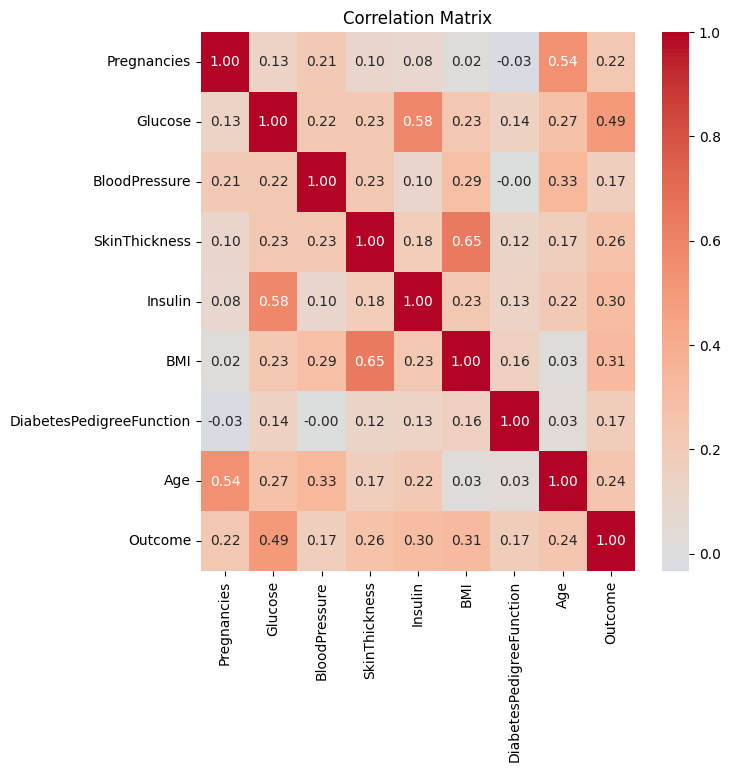

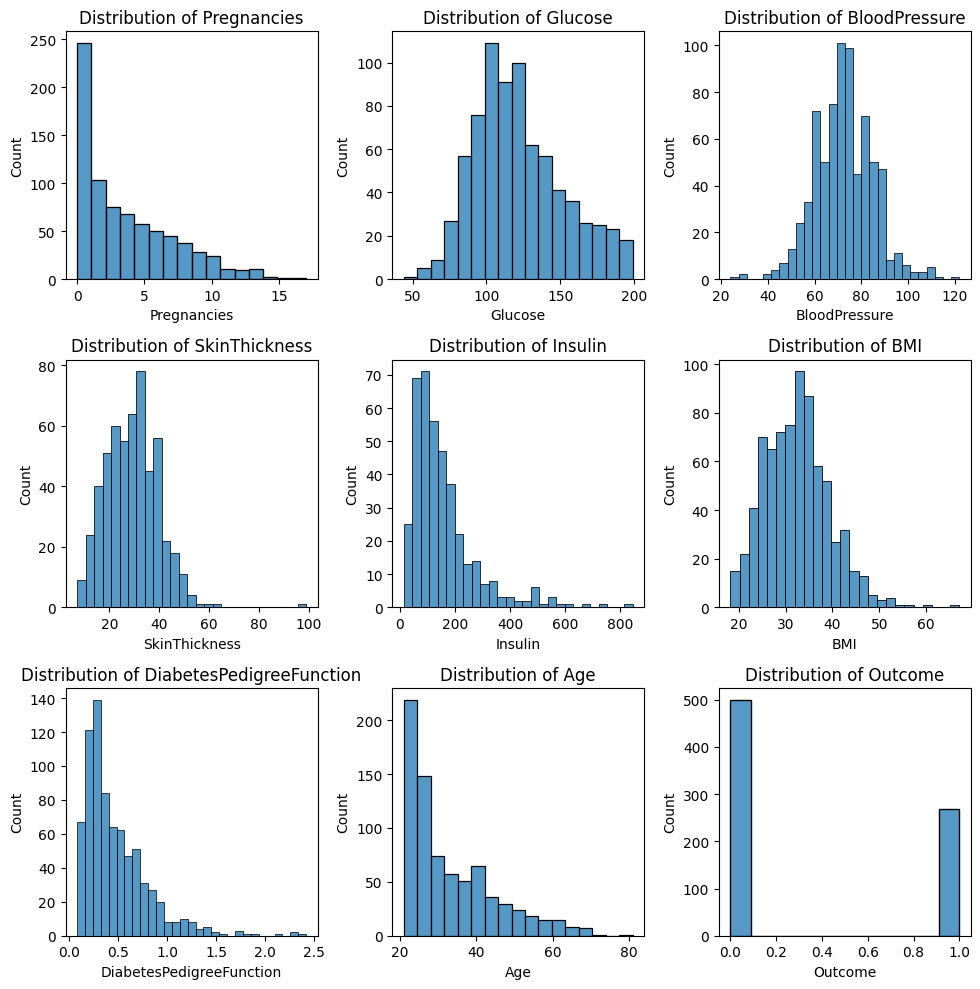

In [12]:
def show_correlation_matrix(df: pd.DataFrame) -> None:
    """
    Display a correlation matrix for the DataFrame.

        Parameters:
    df (pd.DataFrame): The DataFrame for which to display the correlation matrix.
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame.")

    correlation_matrix = df.corr()
    plt.figure(figsize=(7, 7))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", center=0, cmap="coolwarm")
    plt.title("Correlation Matrix")
    plt.show()


def show_values_distribution(df: pd.DataFrame, columns: list[str],
                             figure_per_row: int, figure_size: tuple[int, int]) -> None:
    """
    Display the distribution of values in a specified column of the DataFrame.

        Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    columns (list[str]): List of column names to display distributions for.
    figure_per_row (int): Number of figures to display per row.
    figure_size (tuple[int, int]): Size of the figures to display.
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame.")
    if not isinstance(columns, list) or not all(isinstance(col, str) for col in columns):
        raise TypeError("Columns must be a list of strings.")
    if not isinstance(figure_per_row, int) or figure_per_row <= 0:
        raise ValueError("figure_per_row must be a positive integer.")
    if not isinstance(figure_size, tuple) or len(figure_size) != 2 or \
       not all(isinstance(size, (int, float)) for size in figure_size):
        raise ValueError("figure_size must be a tuple of two positive integers or floats.")

    num_columns = len(columns)
    num_rows = (num_columns + figure_per_row - 1) // figure_per_row
    _, axes = plt.subplots(num_rows, figure_per_row, figsize=figure_size)

    for i, column in enumerate(columns):
        if column not in df.columns:
            raise ValueError(f"Column '{column}' does not exist in the DataFrame.")
        ax = axes[i // figure_per_row, i % figure_per_row]
        sns.histplot(df[column].dropna(), ax=ax)
        ax.set_title(f"Distribution of {column}")
        ax.set_xlabel(column)
        ax.set_ylabel("Count")

    plt.tight_layout()
    plt.show()


show_correlation_matrix(full_dataset)
numerical_columns = full_dataset.select_dtypes(include=[np.number]).columns.tolist()
show_values_distribution(full_dataset, numerical_columns, figure_per_row=3, figure_size=(10, 10))

### Feature Discretisation

In [13]:
def bin_column(df: pd.DataFrame, column_name: str, num_bins: int) -> None:
    """
    Bin a specified column in the DataFrame into a given number of bins using quantile-based
    binning to create bins that contain approximately equal numbers of samples. The first and last
    bounds are set to -inf and inf, respectively, to include all values outside the generated bins.
    The function modifies the DataFrame in place.

        Parameters:
    df (pd.DataFrame): The DataFrame containing the column to be binned.
    column_name (str): The name of the column to be binned.
    num_bins (int): The number of bins to create.
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame.")
    if not isinstance(column_name, str):
        raise TypeError("Column name must be a string.")
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the DataFrame.")
    if not isinstance(num_bins, int) or num_bins <= 0:
        raise ValueError("Number of bins must be a positive integer.")

    _, generated_bins = pd.qcut(df[column_name], num_bins, retbins=True)
    generated_bins = np.unique(generated_bins)
    generated_bins[0], generated_bins[-1] = -np.inf, np.inf
    df[column_name] = pd.cut(df[column_name], bins=generated_bins)


dataset = full_dataset.copy()
bin_column(dataset, "Glucose", 5)
bin_column(dataset, "BloodPressure", 3)
bin_column(dataset, "SkinThickness", 3)
bin_column(dataset, "Insulin", 5)
bin_column(dataset, "BMI", 3)
bin_column(dataset, "DiabetesPedigreeFunction", 3)
bin_column(dataset, "Age", 5)
bin_column(dataset, "Pregnancies", 3)

# Model definition

In [ ]:
# Creating a bayesian network based on the dataset parameters
network = BayesianNetwork()

# Creating the nodes
network.add_node("Age")
network.add_node("DiabetesPedigreeFunction")
network.add_node("Pregnancies")
network.add_node("BMI")
network.add_node("BloodPressure")
network.add_node("SkinThickness")
network.add_node("Glucose")
network.add_node("Insulin")
network.add_node("Outcome")

# Creating the edges between the nodes
network.add_edge("Outcome", "Age")
network.add_edge("Outcome", "DiabetesPedigreeFunction")
network.add_edge("Outcome", "Pregnancies")
network.add_edge("Outcome", "BMI")
network.add_edge("Outcome", "BloodPressure")
network.add_edge("Outcome", "SkinThickness")
network.add_edge("Outcome", "Glucose")
network.add_edge("Outcome", "Insulin")

network.add_edge("Age", "Pregnancies")
network.add_edge("Pregnancies", "Insulin")
network.add_edge("Insulin", "Glucose")
network.add_edge("Insulin", "BMI")
network.add_edge("BMI", "BloodPressure")
network.add_edge("BMI", "SkinThickness")

# Sorting the nodes in topological order
network.sort_nodes()

### Network Visualisation

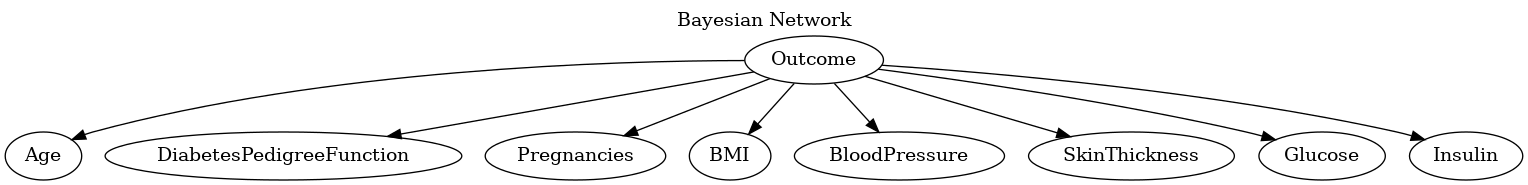

In [28]:
def draw_bayesian_network(dot: graphviz.Digraph, bn: BayesianNetwork) -> None:
    """
    Draws the Bayesian Network using graphviz.
    This function recursively draws nodes and edges of the Bayesian Network.

        Parameters:
    dot (graphviz.Digraph): The graphviz Digraph object to draw the network on.
    bn (BayesianNetwork): The Bayesian Network to be drawn.
    """
    if not isinstance(dot, graphviz.Digraph):
        raise TypeError("dot must be a graphviz.Digraph object.")
    if not isinstance(bn, BayesianNetwork):
        raise TypeError("bn must be a BayesianNetwork object.")

    drawn = set()

    def draw_node(dot, node):
        if node.name in drawn:
            return
        drawn.add(node.name)
        dot.node(node.name, label=node.name)
        for child in node.children:
            draw_node(dot, child)
            dot.edge(node.name, child.name)

    for node in bn.nodes:
        draw_node(dot, node)


# Create a directed graph using graphviz to represent the Bayesian Network
dot = graphviz.Digraph(graph_attr={'label': 'Bayesian Network', 'labelloc': 't'})
draw_bayesian_network(dot, network)

# Display the Bayesian Network as a PNG image
Image(dot.pipe(format='png'))

# Model Evaluation

AUC: 0.819


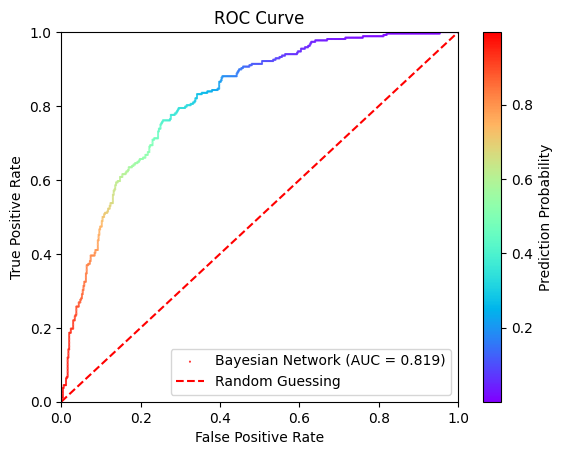

Estimated best threshold: 0.418 | Specificity: 0.748	Sensitivity: 0.750
Calculated statistics for threshold: 0.418


,Predicted Positive,Predicted Negative
Actual Positive,200,68
Actual Negative,128,372


Precision: 0.610	Accuracy: 0.745
Recall:    0.746	F1 Score: 0.671


In [32]:
def iterate_cross_validation(dataset: pd.DataFrame, fold: int = 10
                             ) -> typing.Iterable[tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Splits the dataset into folds for cross-validation.

        Parameters:
    dataset (pd.DataFrame): The dataset to be split.
    fold (int): The number of folds for cross-validation (default is 10).

        Returns:
    typing.Generator[tuple[pd.DataFrame, pd.DataFrame]]:
    A generator yielding tuples of training and test datasets for each fold.
    """
    if not isinstance(dataset, pd.DataFrame):
        raise TypeError("dataset must be a pandas DataFrame.")
    if not isinstance(fold, int) or fold <= 1:
        raise ValueError("fold must be a positive integer greater than 1.")
    if fold > len(dataset):
        raise ValueError("fold cannot be greater than the number of samples in the dataset.")

    shuffled_training_dataset = dataset.sample(frac=1)
    split_training_dataset = [
        shuffled_training_dataset.iloc[
            i * len(dataset) // fold:(i+1) * len(dataset) // fold, :
        ] for i in range(0, fold)
    ]
    for i in range(fold):
        train_data = pd.concat(split_training_dataset[:i] + split_training_dataset[i+1:])
        test_data = split_training_dataset[i]
        yield train_data, test_data


def cross_validated_confusion_matrix(network: BayesianNetwork, dataset: pd.DataFrame, alpha: float = 1,
                                     threshold: float = 0.5, fold: int = 10) -> tuple[int, int, int, int]:
    """
    Trains the Bayesian Network using cross-validation and returns the confusion matrix values.

        Parameters:
    network (BayesianNetwork): The Bayesian Network to be trained.
    dataset (pd.DataFrame): The dataset to train the network on.
    alpha (float): The smoothing parameter for estimating probabilities (default is 1).
    threshold (float): The threshold for classifying a positive outcome (default is 0.5).
    fold (int): The number of folds for cross-validation (default is 10).

        Returns:
    tuple[int, int, int, int]: A tuple containing the counts of true positives (TP), true negatives (TN),
                               false positives (FP), and false negatives (FN).
    """
    if not isinstance(network, BayesianNetwork):
        raise TypeError("network must be a BayesianNetwork object.")
    if not isinstance(threshold, (int, float)) or not (0 <= threshold <= 1):
        raise ValueError("threshold must be a number between 0 and 1.")

    tp, tn, fp, fn = 0, 0, 0, 0
    for train_data, test_data in iterate_cross_validation(dataset, fold):
        network.estimate_probabilities(train_data, alpha=alpha)
        for _, row in test_data.iterrows():
            evidence = {col: row[col] for col in row.index if col != "Outcome" and not pd.isna(row[col])}
            result = inference_variable_elimination(network, "Outcome", evidence)
            expected = row["Outcome"]
            prob = result[1]
            if prob >= threshold and expected == 1:
                tp += 1
            elif prob < threshold and expected == 0:
                tn += 1
            elif prob >= threshold and expected == 0:
                fp += 1
            else:
                fn += 1
    return tp, tn, fp, fn


def show_confusion_matrix_and_statistics(network: BayesianNetwork, dataset: pd.DataFrame,
                                         threshold: float, fold: int = 10) -> None:
    """
    Displays the confusion matrix in a formatted way.

        Parameters:
    tp (int): True Positives count.
    tn (int): True Negatives count.
    fp (int): False Positives count.
    fn (int): False Negatives count.
    """
    tp, tn, fp, fn = cross_validated_confusion_matrix(network, dataset, threshold=threshold, fold=fold)
    print(f"Calculated statistics for threshold: {threshold:.3f}")

    display(pd.DataFrame({
        "Predicted Positive": [tp, fp],
        "Predicted Negative": [fn, tn]
    }, index=["Actual Positive", "Actual Negative"]))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    f1_score = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
    print(f"Precision: {precision:.3f}\tAccuracy: {accuracy:.3f}")
    print(f"Recall:    {recall:.3f}\tF1 Score: {f1_score:.3f}")


def cross_validated_roc_curve_and_auc(network: BayesianNetwork, dataset: pd.DataFrame, alpha: float = 1,
                                      fold: int = 10) -> tuple[list[tuple[float, float, float]], float]:
    """
    Calculates the points for the ROC curve and the area under the curve for the given dataset.

        Parameters:
    network (BayesianNetwork): The Bayesian Network to be evaluated.
    dataset (pd.DataFrame): The dataset to evaluate the network on.
    alpha (float): The smoothing parameter for estimating probabilities (default is 1).
    fold (int): The number of folds for cross-validation (default is 10).

        Returns:
    tuple[float, list[tuple[float, float, float]]]:
    A tuple containing the AUC score and a list of points representing the false positive rate,
    true positive rate, and prediction probability.
    """
    actual = []
    predicted_probs = []

    tp, fp = 0, 0
    for train_data, test_data in iterate_cross_validation(dataset, fold):
        network.estimate_probabilities(train_data, alpha=alpha)
        for _, row in test_data.iterrows():
            evidence = {col: row[col] for col in row.index if col != "Outcome" and not pd.isna(row[col])}
            prob = inference_variable_elimination(network, "Outcome", evidence)
            actual.append(row["Outcome"])
            predicted_probs.append(prob[1])

    total_real_positive = sum(actual)
    total_real_netagive = len(actual) - total_real_positive

    sorted_pairs = sorted(zip(predicted_probs, actual), reverse=True)
    points = []

    auc = 0
    prev_tp, prev_fp = 0, 0
    tp, fp = 0, 0
    for prob, actual in sorted_pairs:
        if actual == 1:
            tp += 1
        else:
            fp += 1

        if fp > prev_fp:
            auc += (tp + prev_tp) / 2
        prev_tp, prev_fp = tp, fp

        points.append((fp / total_real_netagive, tp / total_real_positive, prob))

    auc /= total_real_positive * total_real_netagive

    return points, auc


def show_roc_curve(points: list[tuple[float, float, float]], auc: float) -> None:
    """
    Displays the ROC curve based on the provided points and AUC score.

        Parameters:
    points (list[tuple[float, float, float]]): A list of points representing the ROC curve,
                                               where each point is a tuple of (FPR, TPR, probability).
    auc (float): The area under the ROC curve.
    """
    if not isinstance(points, list) or not all(isinstance(p, tuple) and len(p) == 3 for p in points):
        raise TypeError("points must be a list of tuples with three elements (FPR, TPR, probability).")
    if not isinstance(auc, (int, float)):
        raise TypeError("auc must be a number.")
    if auc < 0 or auc > 1:
        raise ValueError("auc must be between 0 and 1.")

    print(f"AUC: {auc:.3f}")
    x, y, color = zip(*points)
    plt.scatter(x, y, s=0.2, c=color, cmap="rainbow", label=f"Bayesian Network (AUC = {auc:.3f})")
    plt.colorbar(label="Prediction Probability")
    plt.plot([0, 1], [0, 1], linestyle="--", color="red", label="Random Guessing")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title("ROC Curve")
    plt.legend()
    plt.show()


def find_best_threshold(points: list[tuple[float, float, float]]) -> tuple[float, float, float]:
    """
    Finds the best threshold for classification based on the ROC curve points.
    The 'best' threshold is defined as the point where sensitivity (TPR) is approximately
    equal to specificity (1 - FPR), which tends to maximize F1 score.

        Parameters:
    points (list[tuple[float, float, float]]): A list of points representing the ROC curve,
                                               where each point is a tuple of (FPR, TPR, probability).

        Returns:
    tuple[float, float, float]: A tuple containing the best threshold probability,
                                the corresponding specificity (1 - FPR), and sensitivity (TPR).
    """
    if not isinstance(points, list) or not all(isinstance(p, tuple) and len(p) == 3 for p in points):
        raise TypeError("points must be a list of tuples with three elements (FPR, TPR, probability).")

    p = 0.5
    for x, y, p in points:
        if 1 - x < y:
            break
    return p, 1 - x, y


def test_bayesian_network_cpt(network: BayesianNetwork, dataset: pd.DataFrame) -> None:
    """
    Tests the Bayesian Network by calculating the ROC curve and AUC,
    finding the best threshold, and displaying the confusion matrix and statistics.

        Parameters:
    network (BayesianNetwork): The Bayesian Network to be tested.
    dataset (pd.DataFrame): The dataset to evaluate the network on.
    """
    points, auc = cross_validated_roc_curve_and_auc(network, dataset)
    show_roc_curve(points, auc)

    best_threshold, specificity, sensitivity = find_best_threshold(points)
    print(f"Estimated best threshold: {best_threshold:.3f} | Specificity: {specificity:.3f}\t"
          f"Sensitivity: {sensitivity:.3f}")
    show_confusion_matrix_and_statistics(network, dataset, threshold=best_threshold, fold=10)


# Test the parameters of the Bayesian Network
test_bayesian_network_cpt(network, dataset)

### Complementary Dataset Validation

Dataset comes from [C.-Y. Chou, D.-Y. Hsu, C.-H. Chou, Predicting the Onset of Diabetes with Machine Learning Methods, *J. Pers. Med.*, **2023**, 13(3), 406](https://doi.org/10.3390/jpm13030406).

In [17]:
path = "data/diabetes2.csv"
raw_larger_dataset = pd.read_csv(path)

In [18]:
raw_larger_dataset.drop(columns=["PatientID"], inplace=True, errors="ignore")
raw_larger_dataset.rename(columns={
    "PlasmaGlucose":          "Glucose",
    "DiastolicBloodPressure": "BloodPressure",
    "TricepsThickness":       "SkinThickness",
    "SerumInsulin":           "Insulin",
    "BMI":                    "BMI",
    "DiabetesPedigree":       "DiabetesPedigreeFunction",
    "Age":                    "Age",
    "Pregnancies":            "Pregnancies",
    "Diabetic":               "Outcome"
}, inplace=True)

raw_larger_dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,3.224533,107.856867,71.220667,28.814000,137.852133,31.509646,0.398968,30.137733,0.333333
std,3.391020,31.981975,16.758716,14.555716,133.068252,9.759000,0.377944,12.089703,0.471420
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200512,0.078044,21.000000,0.000000
25%,0.000000,84.000000,58.000000,15.000000,39.000000,21.259887,0.137743,22.000000,0.000000
50%,2.000000,104.000000,72.000000,31.000000,83.000000,31.767940,0.200297,24.000000,0.000000
75%,6.000000,129.000000,85.000000,41.000000,195.000000,39.259692,0.616285,35.000000,1.000000
max,14.000000,192.000000,117.000000,93.000000,799.000000,56.034628,2.301594,77.000000,1.000000


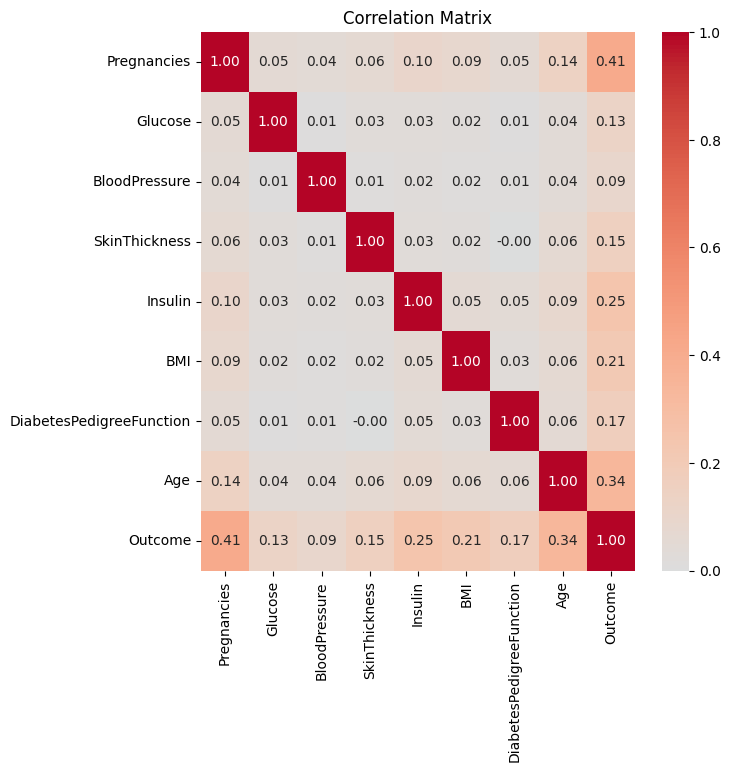

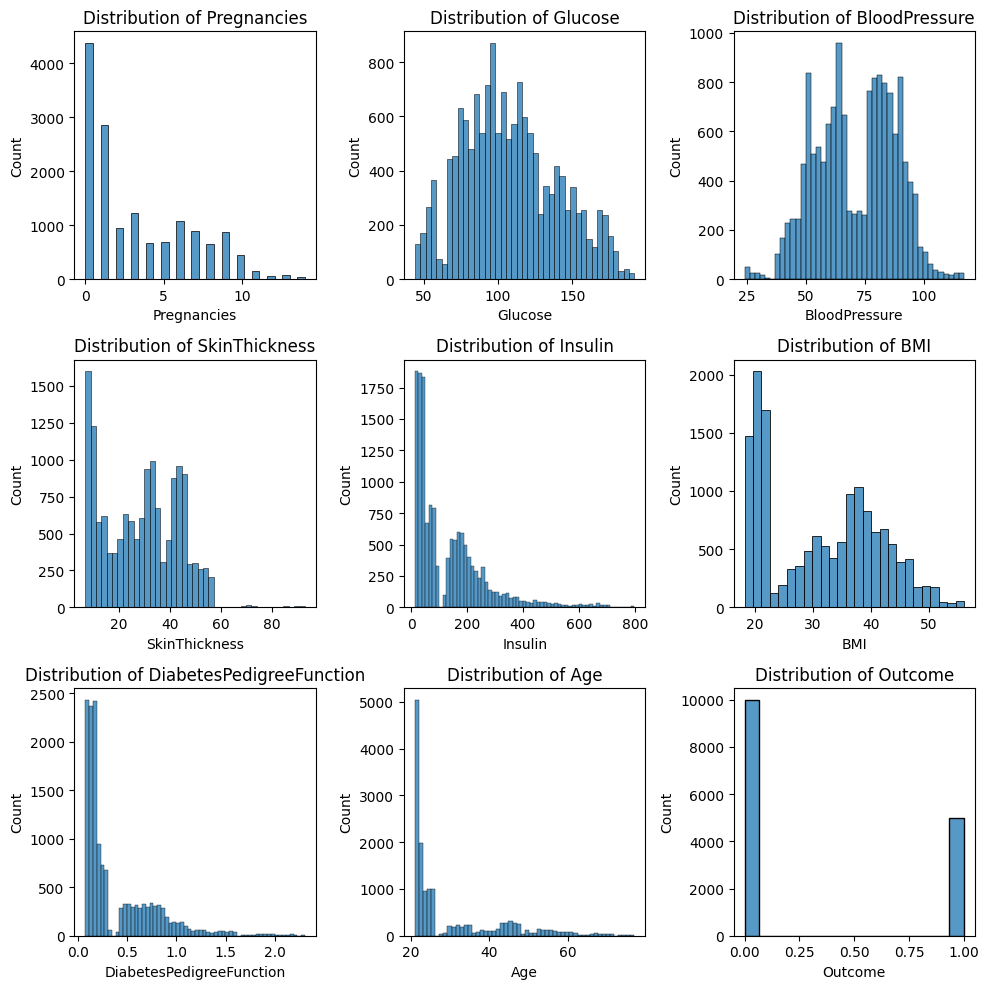

In [19]:
non_null_columns = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
full_larger_dataset = replace_zeros_with_nan(raw_larger_dataset, non_null_columns)

show_correlation_matrix(full_larger_dataset)
numerical_columns = full_larger_dataset.select_dtypes(include=[np.number]).columns.tolist()
show_values_distribution(full_larger_dataset, numerical_columns, figure_per_row=3, figure_size=(10, 10))

In [20]:
larger_dataset = full_larger_dataset.copy()
bin_column(larger_dataset, "Glucose", 5)
bin_column(larger_dataset, "BloodPressure", 3)
bin_column(larger_dataset, "SkinThickness", 3)
bin_column(larger_dataset, "Insulin", 5)
bin_column(larger_dataset, "BMI", 3)
bin_column(larger_dataset, "DiabetesPedigreeFunction", 3)
bin_column(larger_dataset, "Age", 5)
bin_column(larger_dataset, "Pregnancies", 3)

AUC: 0.974


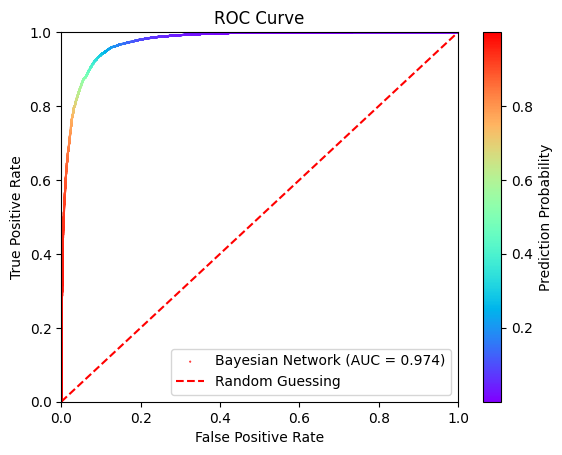

Estimated best threshold: 0.378 | Specificity: 0.918	Sensitivity: 0.918
Calculated statistics for threshold: 0.378


,Predicted Positive,Predicted Negative
Actual Positive,4588,412
Actual Negative,824,9176


Precision: 0.848	Accuracy: 0.918
Recall:    0.918	F1 Score: 0.881


In [33]:
test_bayesian_network_cpt(network, larger_dataset)